In [8]:
%matplotlib inline
from __future__ import division, print_function
import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
from astropy import units as u
import fitsio
import pandas as pd
from astropy.coordinates import SkyCoord
import sys, os, time, argparse, glob
import matplotlib.patches as patches

from desitarget.targetmask import desi_mask

import astropy.units
import healpy as hp

In [2]:
class Point:

    def __init__(self, xcoord=0, ycoord=0):
        self.x = xcoord
        self.y = ycoord

class Rectangle:
    def __init__(self, bottom_left, top_right, colour):
        self.bottom_left = bottom_left
        self.top_right = top_right
        self.colour = colour

    def intersects(self, other):
        return not (self.top_right.x <= other.bottom_left.x or self.bottom_left.x >= other.top_right.x or self.top_right.y <= other.bottom_left.y or self.bottom_left.y >= other.top_right.y)
    
    def plot(self, other):
        fig, ax = plt.subplots(figsize=(15,8))
        rect = patches.Rectangle((self.bottom_left.x,self.bottom_left.y), abs(self.top_right.x - self.bottom_left.x), abs(self.top_right.y - self.bottom_left.y),linewidth=1.5, alpha=0.5, color='r')
        rect2 = patches.Rectangle((other.bottom_left.x,other.bottom_left.y), abs(other.top_right.x - other.bottom_left.x), abs(other.top_right.y - other.bottom_left.y),linewidth=1.5, alpha=0.5, color='blue')
        ax.add_patch(rect)
        ax.add_patch(rect2)
        xlims = np.array([self.bottom_left.x, self.top_right.x, other.bottom_left.x, other.top_right.x])
        ylims = np.array([self.bottom_left.y, self.top_right.y, other.bottom_left.y, other.top_right.y])
        ax.set_xlim(xlims.min()-1, xlims.max()+1)
        ax.set_ylim(ylims.min()-1, ylims.max()+1)
        #plt.show()

In [3]:
def cut(ramin, ramax, decmin, decmax, catalog):
    
    mask = np.logical_and(catalog['RA'] >= ramin, catalog['RA'] <= ramax)
    mask &= np.logical_and(catalog['DEC'] >= decmin, catalog['DEC'] <= decmax)
    cat = catalog[mask]
    #print('CUT #:',len(cat))
    
    return cat

In [4]:
def cut_sweeps(ramin, ramax, decmin, decmax, sweep_dir):
    
    cat1_paths = sorted(glob.glob(os.path.join(sweep_dir, '*.fits')))
    #cat = np.empty()
    j = 0
    
    for fileindex in range(len(cat1_paths)):
    #for fileindex in range(5):

        cat1_path = cat1_paths[fileindex]
        filename = cat1_path[-26:-5]
        brick = cat1_path[-20:-5]
        ra1min = float(brick[0:3])
        ra1max = float(brick[8:11])
        dec1min = float(brick[4:7])
        if brick[3]=='m':
            dec1min = -dec1min
        dec1max = float(brick[-3:])
        if brick[-4]=='m':
            dec1max = -dec1max
        
        r1=Rectangle(Point(ramin,decmin), Point(ramax, decmax), 'red')
        r2=Rectangle(Point(ra1min, dec1min), Point(ra1max, dec1max), 'blue')
        
        if not r1.intersects(r2):
            continue
        
        if j == 0:
            cat = fitsio.read(cat1_path)
            cat = cut(ramin, ramax, decmin, decmax, cat)
            print(filename, len(cat))
            j += 1
            continue
        
        name = fitsio.read(cat1_path)
        name = cut(ramin, ramax, decmin, decmax, name)
        print(filename, len(name))
        
        cat = np.concatenate((cat, name))
        j += 1
        
    print('Bricks that matched: %i' %(j))
    print('Sample region # objects: %i' %(len(cat)))
    
    return cat

In [5]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

### DECaLS DR7 catalogue
 
 This catalogue was taken from 'desitarget' at: /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/targets-dr7.1-0.22.0.fits 
 
 For more info see email: [desi-bgs 1069] Official DR7 Target Release
 
..........

 To get BGS selection (non PSF and r < 20) using 'desitarget' use:
 
  mask &= ((cat0["DESI_TARGET"] & desi_mask["BGS_ANY"])!=0)
  
  To print columns names of fits file with fitsio.read(fits_file) use:
  
  dataframe.dtype.names

In [6]:
def load_cat(catalog):
    
    # Load DESI target catalog
    columns0 = ['RA', 'DEC', 'TYPE', 'DESI_TARGET', 'BRIGHTSTARINBLOB', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R','MW_TRANSMISSION_Z']
    cat0 = fitsio.read(catalog, columns=columns0)
    print('Lenght full DR7',len(cat0))

    #rflux =  cat0['FLUX_R']/cat0['MW_TRANSMISSION_R']
    #gflux  = cat0['FLUX_G']/cat0['MW_TRANSMISSION_G']
    #zflux  = cat0['FLUX_Z']/cat0['MW_TRANSMISSION_Z']
    
    # Require 2+ exposures in grz
    mask = (cat0['NOBS_G']>=3) & (cat0['NOBS_R']>=3) & (cat0['NOBS_Z']>=3)
    mask &= (cat0['FLUX_R'] > 0) & (cat0['FLUX_G'] > 0) & (cat0['FLUX_Z'] > 0)
    #Require observations in the g,r,z bands
    #mask = (gflux>=1) & (rflux>=1) & (zflux>=1)
    # Select BGS
    #mask &= ((cat0["DESI_TARGET"] & desi_mask["BGS_ANY"])!=0)
    idx = np.where(mask)

    columns = ['RA', 'DEC', 'TYPE', 'DESI_TARGET', 'BRIGHTSTARINBLOB', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R','MW_TRANSMISSION_Z']
    cat = fitsio.read(catalog, columns=columns, rows=idx)
    #print('Lenght DR7 withat least 2 obs and BGS_ANY mask',len(cat))
    print('Lenght DR7 with at least 3 obs',len(cat))

    return cat, cat0

In [8]:
cat, cat0 = load_cat('targets-dr7.1-0.23.0.fits')

Lenght full DR7 72660205
Lenght DR7 with at least 3 obs 31019744


In [230]:
def nobs_plot(cat0, NOBS, MAX):
    
    import matplotlib.patches as patches

    rfluxtmp =  cat0['FLUX_R']/cat0['MW_TRANSMISSION_R']
    #mask = flux_to_mag(rfluxtmp) <= 20
    mask = (cat0['NOBS_G']>=MAX) & (cat0['NOBS_R']>=MAX) & (cat0['NOBS_Z']>=MAX)
    cat0tmp = cat0[mask]
    print(len(cat0tmp))

    fig, ax = plt.subplots(figsize=(20,10))
    cax = ax.scatter(cat0tmp['RA'][::1], cat0tmp['DEC'][::1], c=cat0tmp[NOBS][::1], cmap=plt.cm.get_cmap('viridis'), s=1)
    rect = patches.Rectangle((200, -2),30,7,linewidth=1.5,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((211.5, -2),12,5,linewidth=1.5,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    ax.set_title('NOBS_R & NOBS_G & NOBS_Z>%i' %(MAX))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'DEC')

    cbar = fig.colorbar(cax)
    cbar.set_label(NOBS)

    plt.show()

In [ ]:
sweep_dir = os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/','dr7', 'sweep', '7.1')
catS = cut_sweeps(200, 230, -2,5, sweep_dir)

sweep-200m005-210p000 1688738
sweep-200p000-210p005 4086987


31073745


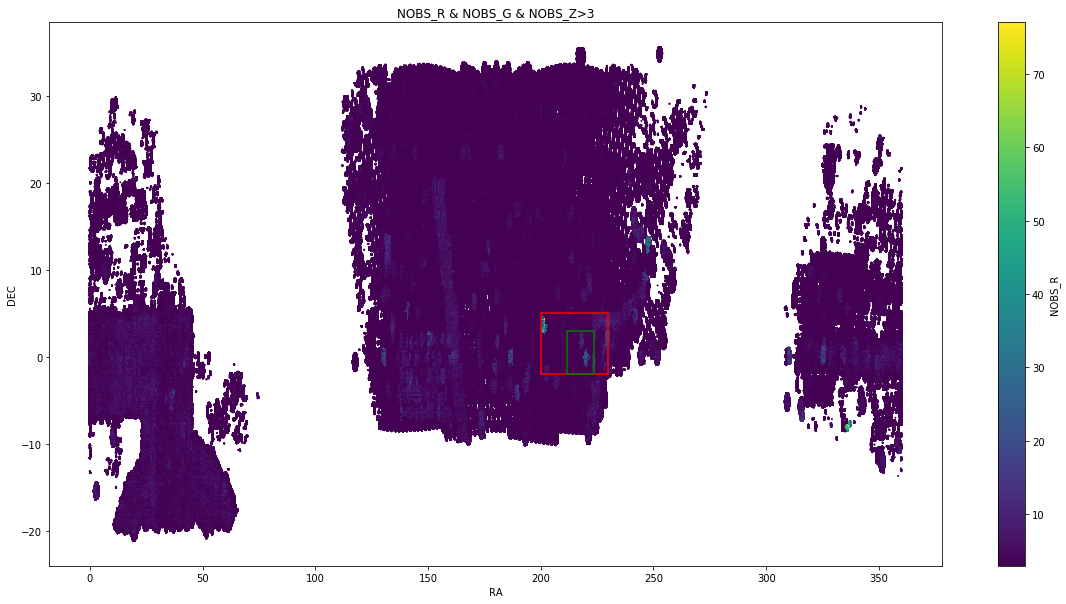

In [231]:
nobs_plot(cat0, 'NOBS_R', 3)

Cut catalogue to sample region:

200 $\leq$ RA $\leq$ 230

-2 $\leq$ DEC $\leq$ +5

In [26]:
def cut(ramin, ramax, decmin, decmax, catalog):
    
    mask = np.logical_and(catalog['RA'] >= ramin, catalog['RA'] <= ramax)
    mask &= np.logical_and(catalog['DEC'] >= decmin, catalog['DEC'] <= decmax)
    cat = catalog[mask]
    print(len(cat))
    
    return cat

In [27]:
catS = cut(200, 230, -2,5, cat)
cat0S = cut(200, 230, -2,5, cat0)

1097106
1557493


1556306


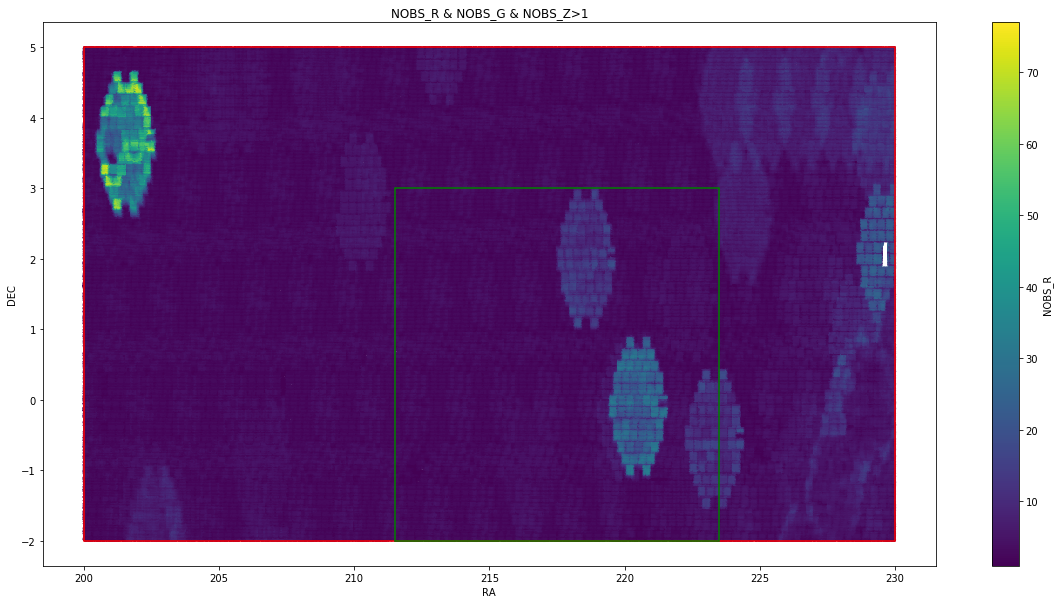

In [34]:
nobs_plot(cat0S, 'NOBS_R', 1)

1098668


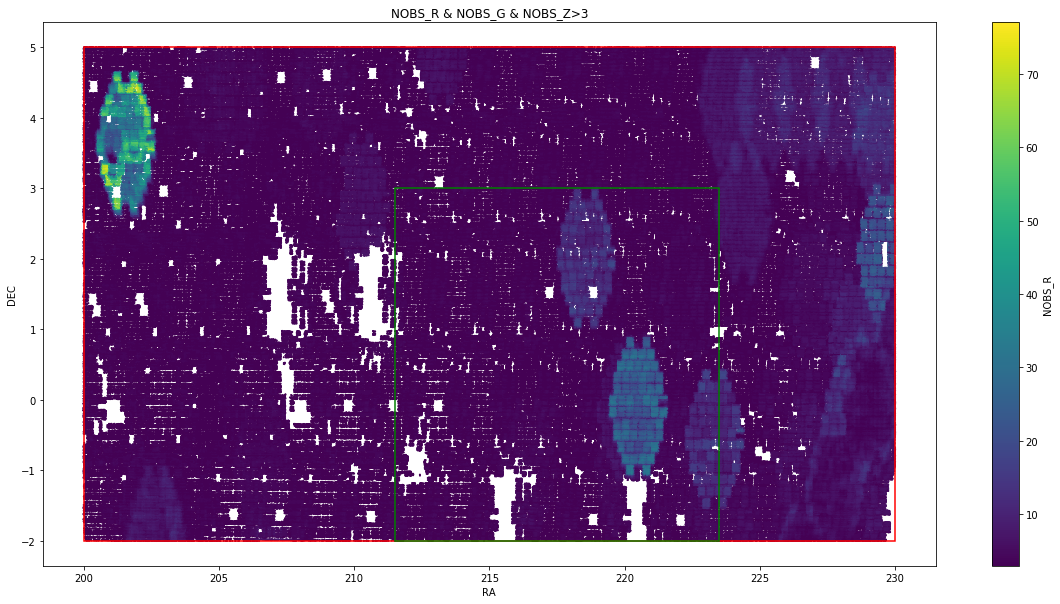

In [35]:
nobs_plot(cat0S, 'NOBS_R', 3)

In [47]:
def mag_hist_decals(df):
    
    print('Full:',len(df))
    #Remember to remove all fluxes <= 0 since the log(<=0)=inf.
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    print('FLUX_[R,G,Z]>=0:',len(df))
    
    rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    
    print('r<=0:',len(df[df['FLUX_R'] <= 0]))
    print('g<=0:',len(df[df['FLUX_G'] <= 0]))
    print('z<=0:',len(df[df['FLUX_Z']<= 0]))
    
    mask_psf = df['TYPE'] == b'PSF '
    #mask_nopsf = df['TYPE'] != b'PSF '
    mask_rex = df['TYPE'] == b'REX '
    mask_dev = df['TYPE'] == b'DEV '
    mask_exp = df['TYPE'] == b'EXP '
    mask_comp = df['TYPE'] == b'COMP '
    bins = np.linspace(16, 25, 100)
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    plt.figure(figsize=(12, 7))
    #plt.hist(zmag[(zmag < 27.5) & mask], 70, label=r'z')
    plt.hist(rmag[(mask_rex)], bins=bins,label=r'r, REX', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_dev)], bins=bins,label=r'r, DEV', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_exp)], bins=bins,label=r'r, EXP', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_comp)], bins=bins,label=r'r, COMP', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_psf)], bins=bins,label=r'r, PSF', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag, bins=bins,label=r'r, All', alpha=1, histtype='step', fill=False)
    #plt.hist(gmag[(gmag < 27.5) & mask], 70,label=r'g', alpha=0.6)
    plt.xlim(16, 25)
    #plt.ylim(0, 1e5)
    plt.legend()
    plt.grid()

In [48]:
#cat2 = cut(200, 230, -2,5, cat)

Full: 1557493
FLUX_[R,G,Z]>=0: 1554588
r<=0: 0
g<=0: 0
z<=0: 0


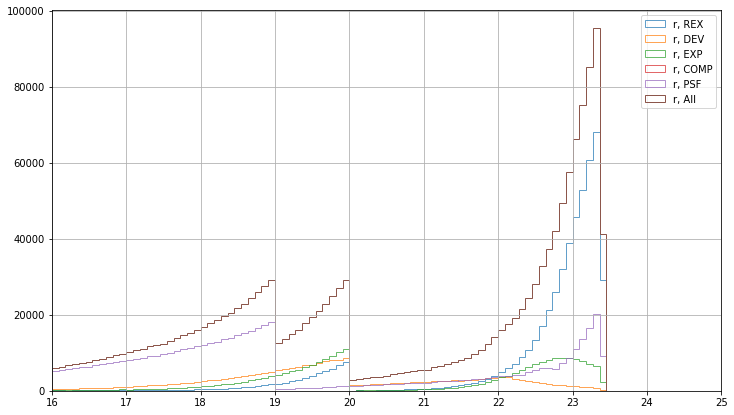

In [49]:
mag_hist_decals(cat0S)

In [14]:
dr5 = '/project/projectdirs/desi/target/catalogs/dr5/0.20.0/targets-dr5-0.20.0.fits'
catdr5 = fitsio.read(dr5)
catdr5.shape

(35385733,)

Full: 35385733
FLUX_[R,G,Z]>=0: 32219639
r<=0: 0
g<=0: 0
z<=0: 0


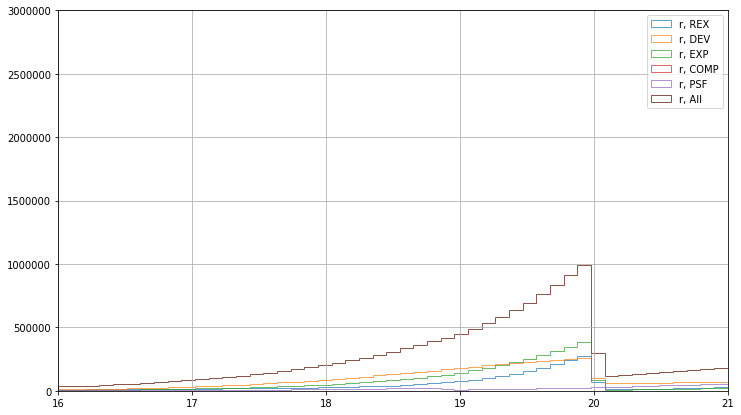

In [22]:
mag_hist_decals(catdr5)

In [40]:
def mag_hist_decals_2(df):
    
    print('Full:',len(df))
    #Remember to remove all fluxes <= 0 since the log(<=0)=inf.
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    print('FLUX_[R,G,Z]>=0:',len(df))
    plt.figure(figsize=(12, 8))
    
    for i in range(1,8):
        
        mask = (df['NOBS_G']==i) & (df['NOBS_R']==i) & (df['NOBS_Z']==i)
        #mask = df['NOBS_R']==i
        cat0tmp = df[mask]
        print(i, len(cat0tmp))
        rmag = flux_to_mag(cat0tmp['FLUX_R']/cat0tmp['MW_TRANSMISSION_R'])
    #gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    #zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    #plt.hist(zmag[zmag < 27.5], 70, label=r'z')
        plt.hist(rmag[rmag < 27.5], 70,label=r'r, NOBS=%g'%(i), alpha=0.7)
    #plt.hist(gmag[gmag < 27.5], 70,label=r'g', alpha=0.6)
        plt.xlim(12, 24)
        plt.legend()
        plt.grid()
        plt.yscale('log')
        
    plt.show()

Full: 72660205
FLUX_[R,G,Z]>=0: 69521036
1 2531358
2 5388334
3 6971934
4 2589459
5 524183
6 206091
7 85896


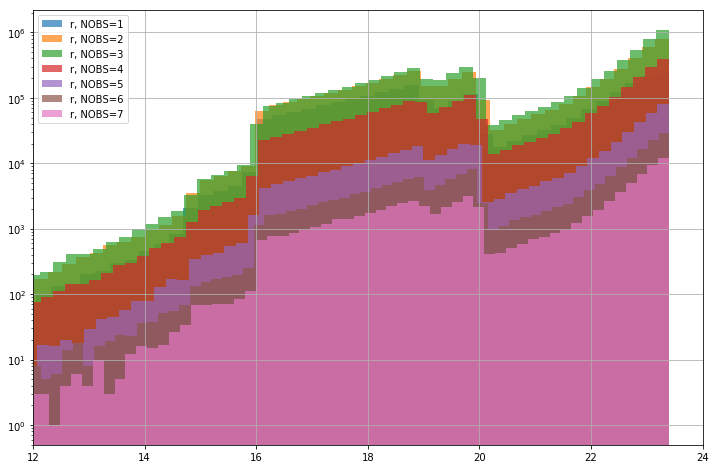

In [41]:
mag_hist_decals_2(cat0)

### GAMA DR3 catalogue
Loading GAMA TilingCat.fits from http://www.gama-survey.org/dr3/schema/table.php?id=3
The Petro mags and model mags come with extinction correction for SDSS DR7.

In [42]:
#Load GAMA TilingCat.fits with astropy Table
gama = Table.read('TilingCat.fits')

In [43]:
#Selecting the G15 field by RA and DEC
gamaS = cut(211.5, 223.5, -2,3, gama)

69563


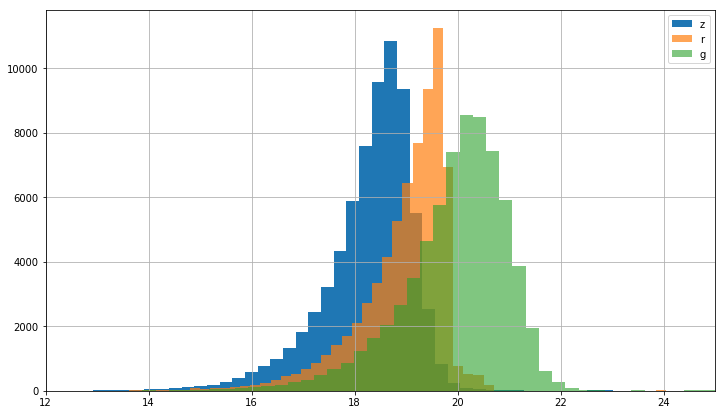

In [44]:
plt.figure(figsize=(12, 7))
plt.hist(gamaS['Z_MODEL'], 70, label=r'z')
plt.hist(gamaS['R_MODEL'], 70,label=r'r', alpha=0.7)
plt.hist(gamaS['G_MODEL'], 70,label=r'g', alpha=0.6)
plt.xlim(12, 25)
plt.legend()
plt.grid()

### SDSS DR14 catalogue

##### SQL query
For this sample we use the following  query:

    SELECT TOP 500000
       p.objid,p.ra,p.dec,p.type,p.insideMask, p.flags, p.flags_r,
    p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
    p.petroMag_u, p.petroMag_g, p.petroMag_r, p.petroMag_i, p.petroMag_z,
    p.extinction_u, p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z
    FROM Galaxy AS p
    WHERE 
        p.ra >= 200 and p.ra <= 230
        AND (p.dec >= -2 and p.dec <= 5)
        AND (p.modelMag_r > 0 and p.modelMag_r <= 20)
        AND ((p.flags_r & 0x10000000) != 0) 
        -- detected in BINNED1 
        AND ((p.flags_r & 0x8100000c00a0) = 0) 
        -- not NOPROFILE, PEAKCENTER, NOTCHECKED, PSF_FLUX_INTERP, SATURATED, 
        -- or BAD_COUNTS_ERROR. 
        -- if you want to accept objects with interpolation problems for PSF mags, 
        -- change this to: AND ((flags_r & 0x800a0) = 0) 
        AND (((p.flags_r & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2)) 
        -- not DEBLEND_NOPEAK or small PSF error 
        -- (substitute psfmagerr in other band as appropriate) 
        AND (((p.flags_r & 0x100000000000) = 0) or (p.flags_r & 0x1000) = 0) 
        -- not INTERP_CENTER or not COSMIC_RAY - omit this AND clause if you want to 
        -- accept objects with interpolation problems for PSF mags. "
      
     ----- 
    import astroquery
    from astroquery.sdss import SDSS
    query = "SELECT TOP 500000 p.objid,p.ra,p.dec,p.type,p.insideMask, p.flags, p.flags_r, p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z, p.petroMag_u, p.petroMag_g, p.petroMag_r, p.petroMag_i, p.petroMag_z, p.extinction_u, p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z FROM Galaxy AS p WHERE p.ra >= 200 and p.ra <= 230 AND (p.dec >= -2 and p.dec <= 5) AND (p.modelMag_r > 0 and p.modelMag_r <= 20) AND ((p.flags_r & 0x10000000) != 0) AND ((p.flags_r & 0x8100000c00a0) = 0) AND (((p.flags_r & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2)) AND (((p.flags_r & 0x100000000000) = 0) or (p.flags_r & 0x1000) = 0) "
    res = SDSS.query_sql(query)
    print(len(res))
    -----

In [45]:
!ls sdss_photo/photo_sdss_14_STA*

sdss_photo/photo_sdss_14_STAR_rmag_0_19.5.fits
sdss_photo/photo_sdss_14_STAR_rmag_19.5_21.fits
sdss_photo/photo_sdss_14_STAR_rmag_21_22.fits
sdss_photo/photo_sdss_14_STAR_rmag_22.5_max.fits
sdss_photo/photo_sdss_14_STAR_rmag_22_22.5.fits


In [62]:
def conca_sdss():
    cat_gal_1 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_0_20.fits')
    cat_gal_2 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_20_21.fits')
    cat_gal_3 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21_21.5.fits')
    cat_gal_4 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21.5_21.8.fits')
    cat_gal_5 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21.8_22.2.fits')
    cat_gal_6 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_22.2_max.fits')
    
    cat_star_1 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_0_19.5.fits')
    cat_star_2 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_19.5_21.fits')
    cat_star_3 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_21_22.fits')
    cat_star_4 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_22.5_max.fits')
    cat_star_5 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_22_22.5.fits')
                             
    cat_gal = np.concatenate((cat_gal_1, cat_gal_2, cat_gal_3, cat_gal_4, cat_gal_5, cat_gal_6))
    cat_star = np.concatenate((cat_star_1, cat_star_2, cat_star_3, cat_star_4, cat_star_5))
    
    #remove objects with flux_[r,g,z] < 0 as we did in DECaLS
    cat_gal = cat_gal[(cat_gal['modelMag_z'] > 0) & (cat_gal['modelMag_r'] > 0) & (cat_gal['modelMag_g'] > 0)]
    cat_star = cat_star[(cat_star['modelMag_z'] > 0) & (cat_star['modelMag_r'] > 0) & (cat_star['modelMag_g'] > 0)]
    
    cat = np.concatenate((cat_gal, cat_star))
    
    print('SDSS #GAL:',len(cat_gal))
    print('SDSS #STAR:',len(cat_star))
    print('SDSS #TOTAL:',len(cat))
    
    return cat, cat_gal, cat_star

In [63]:
sdss, sdss_gal, sdss_star = conca_sdss()

SDSS #GAL: 2310433
SDSS #STAR: 1908553
SDSS #TOTAL: 4218986


In [48]:
def mag_hist_sdss(df):
    
    rmag = df['modelMag_r']-df['extinction_r']
    gmag = df['modelMag_g']-df['extinction_g']
    zmag = df['modelMag_z']-df['extinction_z']
    rmagS = np.logical_and(rmag > 12, rmag < 26)
    gmagS = np.logical_and(gmag > 12, gmag < 26)
    zmagS = np.logical_and(zmag > 12, zmag < 26)
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    plt.figure(figsize=(12, 7))
    plt.hist(zmag[zmagS], 50, label=r'z')
    plt.hist(rmag[rmagS], 50, label=r'r', alpha=0.7)
    plt.hist(gmag[gmagS], 50, label=r'g', alpha=0.6)
    plt.xlim(12, 26)
    plt.legend()
    plt.grid()

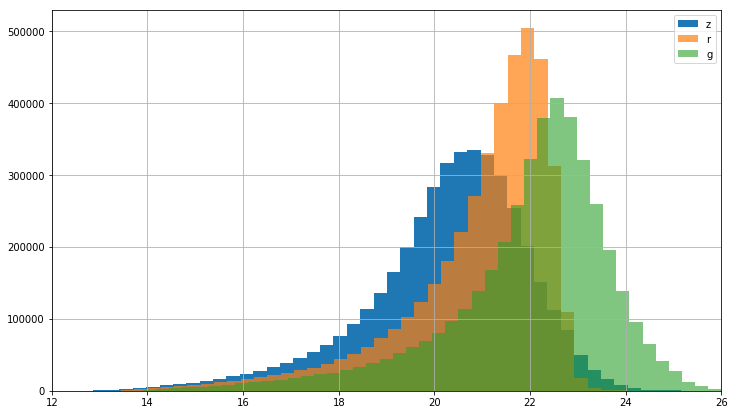

In [49]:
mag_hist_sdss(sdss)

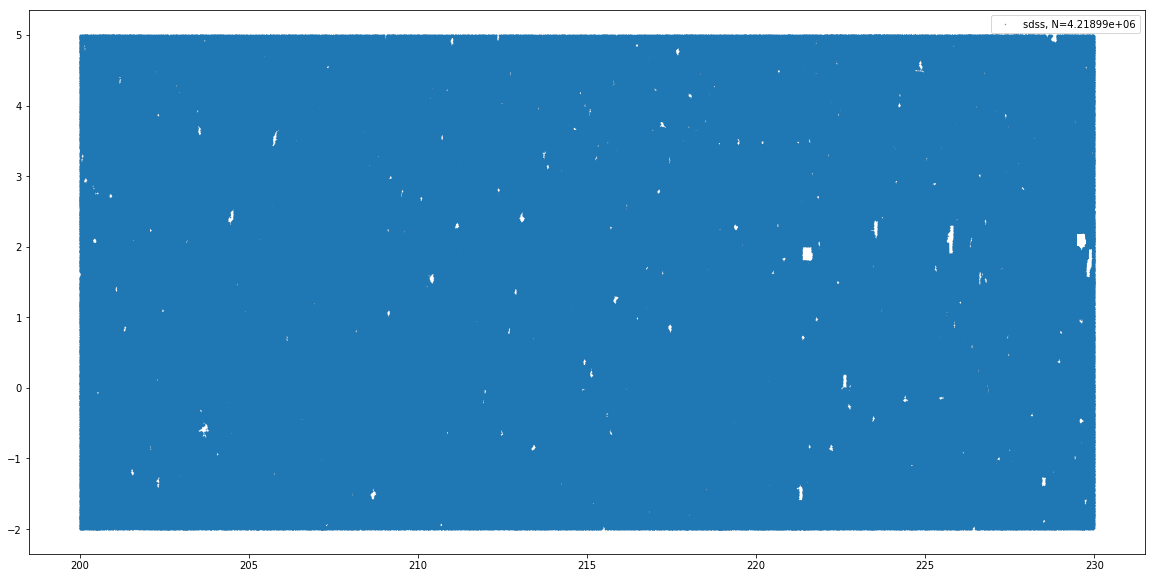

In [90]:
plt.figure(figsize=(20, 10))
#plt.plot(catS['RA'], catS['DEC'], '.', markersize=0.5, alpha=1, label = 'decals, N=%g'%(len(catS)))
plt.plot(sdss['ra'], sdss['dec'], '.', markersize=0.9, alpha=0.8, label = 'sdss, N=%g'%(len(sdss)))
#plt.plot(gamaS['RA'], gamaS['DEC'], '.', markersize=0.8, alpha=0.7, label = 'gama, N=%g'%(len(gamaS)))

plt.legend()
plt.show()

## RANDOMS

In [70]:
randoms = fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/randoms-dr7.1-0.22.0.fits')

In [78]:
ran0S = cut(200, 230, -2,5, randoms)
ranS = ran0S[(ran0S['NOBS_G']>=3) & (ran0S['NOBS_R']>=3) & (ran0S['NOBS_Z']>=3)]
print('#ran0S:', len(ran0S))
print('#ranS:', len(ranS))

20972586
#ran0S: 20972586
#ranS: 14449927


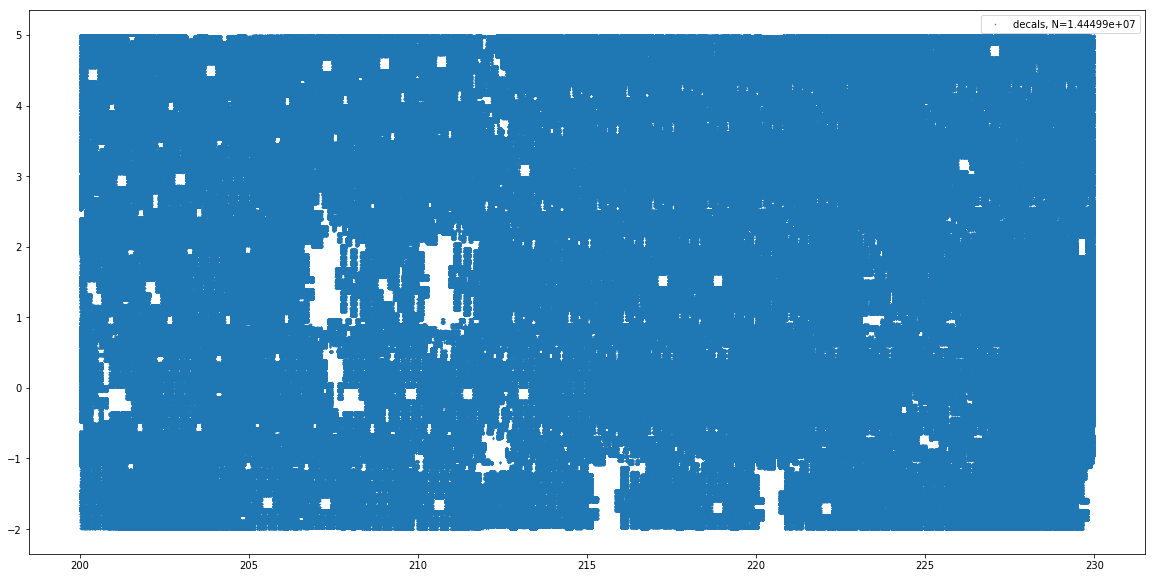

In [205]:
plt.figure(figsize=(20, 10))
plt.plot(ranS['RA'], ranS['DEC'], '.', markersize=1, alpha=1, label = 'decals, N=%g'%(len(ranS)))

plt.legend()
plt.show()

In [84]:
#pixw = fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/pixweight-dr7.1-0.22.0.fits')

In [237]:
def pixmap(RA, DEC, N):
    #theta = 0.5 * np.pi - np.deg2rad(dec)
    #phi = np.deg2rad(ra)
    #N = 512
    m = hp.ang2pix(N, RA, DEC, nest=False, lonlat=True)

    def gen_fast_map(ip_, nside=N):
        npixel  = hp.nside2npix(nside)
        print(npixel)
        map_ = np.bincount(ip_,minlength=npixel)
        return map_

    map = gen_fast_map(m)
    hp.cartview(map, lonra=[200 - 360, 230 - 360], latra=[-2,5])
    #hp.cartview(map)

3145728


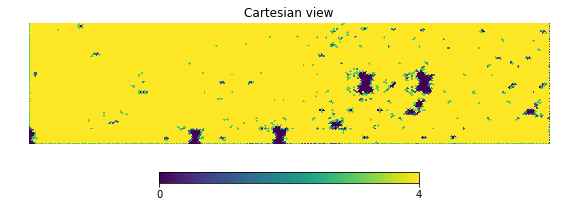

In [238]:
pixmap(ra, dec, 256*2)

3145728


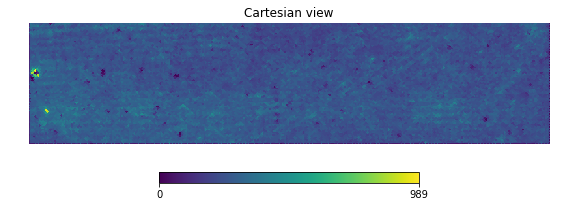

In [224]:
pixmap(sdss['ra'], sdss['dec'], 256*2)

## DEV zone

In [ ]:
#theta = 0.5 * np.pi - np.deg2rad(dec)
#phi = np.deg2rad(ra)
N = 512
m = hp.ang2pix(N, ra, dec, nest=False, lonlat=True)

def gen_fast_map(ip_, nside=N):
    npixel  = hp.nside2npix(nside)
    print(npixel)
    map_ = np.bincount(ip_,minlength=npixel)
    return map_

map = gen_fast_map(m)
hp.cartview(map, lonra=[200 - 360, 230 - 360], latra=[-2,5])
#hp.cartview(map)

In [ ]:
from skymapper import skymapper as skm

# load RA/Dec from catalog [not implemented]
ra, dec = ranS['RA'], ranS['DEC']

# get count in healpix cells (as vertices), restrict to non-empty cells
nside = 1024
bc, ra, dec, vertices = skm.getCountAtLocations(ra, dec, nside=nside, return_vertices=True)

# setup figure
import matplotlib.cm as cm
cmap = cm.YlOrRd
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111, aspect='equal')

# setup map: define AEA map optimal for given RA/Dec
proj = skm.createConicMap(ax, ra, dec, proj_class=skm.AlbersEqualAreaProjection)
# add lines and labels for meridians/parallels (separation 5 deg)
sep = 5
meridians = np.arange(-90, 90+sep, sep)
parallels = np.arange(0, 360+sep, sep)
skm.setMeridianPatches(ax, proj, meridians, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setParallelPatches(ax, proj, parallels, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setMeridianLabels(ax, proj, meridians, loc="left", fmt=skm.pmDegFormatter)
skm.setParallelLabels(ax, proj, parallels, loc="bottom")

# add vertices as polygons
vmin, vmax = np.percentile(bc,[10,90])
poly = skm.addPolygons(vertices, proj, ax, color=bc, vmin=vmin, vmax=vmax, cmap=cmap, zorder=3, rasterized=True)

# add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.0)
cb = fig.colorbar(poly, cax=cax)
cb.set_label('$n_g$ [arcmin$^{-2}$]')
cb.solids.set_edgecolor("face")

# show (and save) ...
fig.tight_layout()
fig.show()
#fig.savefig(imagefile)

In [8]:
#del test_c
    
test_c = np.empty(len(gama), dtype='S3')
j = 0
for word in gama['SPECID']:
    if word.startswith('G15'):
        test_c[j] = str(word[:3])
        #print(j, str(word[:3]))
    
    j = j + 1
    
#del gama['new']
#del gama['G15']

gama['field'] = test_c

In [30]:
gama_g15 = gama[gama['field'] == b'G15']
gama_g15 = gama_g15.to_pandas()
gama_p = gama.to_pandas()

In [38]:
gama_p['SURVEY'].value_counts()
#clean = gama.replace('NULL', nan)
#clean = gama.dropna()
#clean[gama['SURVEY']].value_counts()

GAMA         133494
SDSS          23228
2dFGRS         2075
MGC             664
6dFGS           171
2QZ             157
WiggleZ          87
VVDS             66
2SLAQ-QSO        32
2SLAQ-LRG        27
GAMA_LT          15
UZC               6
NED               4
Name: SURVEY, dtype: int64

In [52]:
decals_sdss = Table.read('decals-dr7.0-sdss-specObj-dr14-unique-trimmed-match.fits')

In [41]:
sdss = Table.read('specObj-dr14.fits')

In [43]:
mask = np.logical_and(sdss['PLUG_RA'] <= gama_g15['RA'].max(), sdss['PLUG_RA'] >= gama_g15['RA'].min())  
mask &= np.logical_and(sdss['PLUG_DEC'] <= gama_g15['DEC'].max(), sdss['PLUG_DEC'] >= gama_g15['DEC'].min())
sdss_g15 = sdss[mask]

In [46]:
sdss_short = Table.read('sdss-specObj-dr14-unique-trimmed.fits')

In [55]:
decals_gama = Table.read('decals-dr7.0-GAMA-DR3-SpecObj-match.fits')

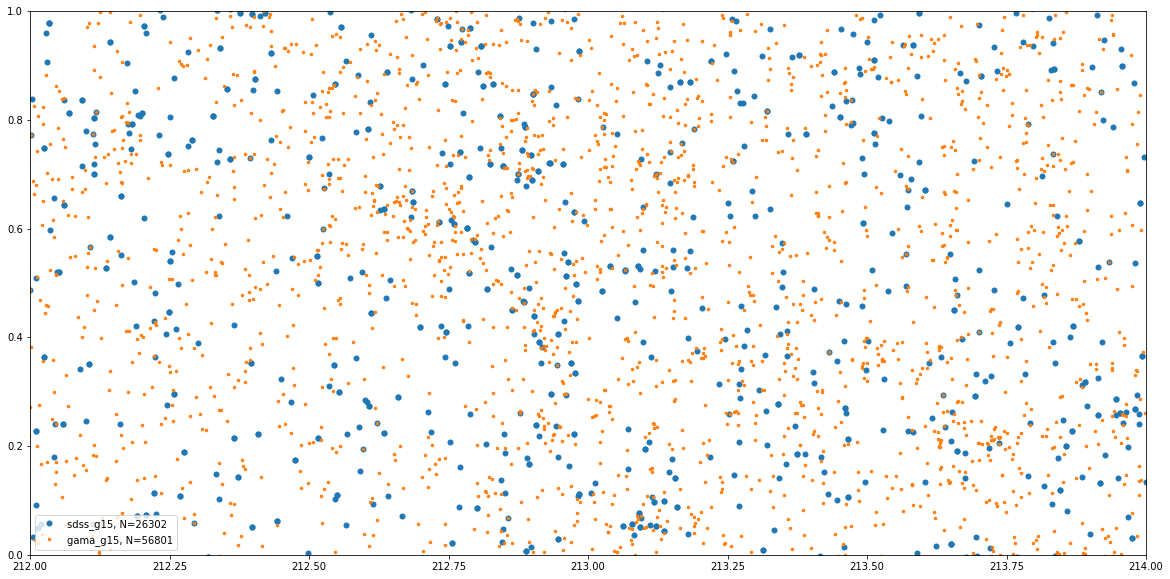

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(sdss_g15['PLUG_RA'], sdss_g15['PLUG_DEC'], 'o', markersize=5, alpha=1, label = 'sdss_g15, N=%g'%(len(sdss_g15)))
plt.plot(gama_g15['RA'], gama_g15['DEC'], '.', markersize=5, alpha=1, label = 'gama_g15, N=%g'%(len(gama_g15)))
plt.axis([212, 214, 0, 1])
plt.legend()
plt.show()

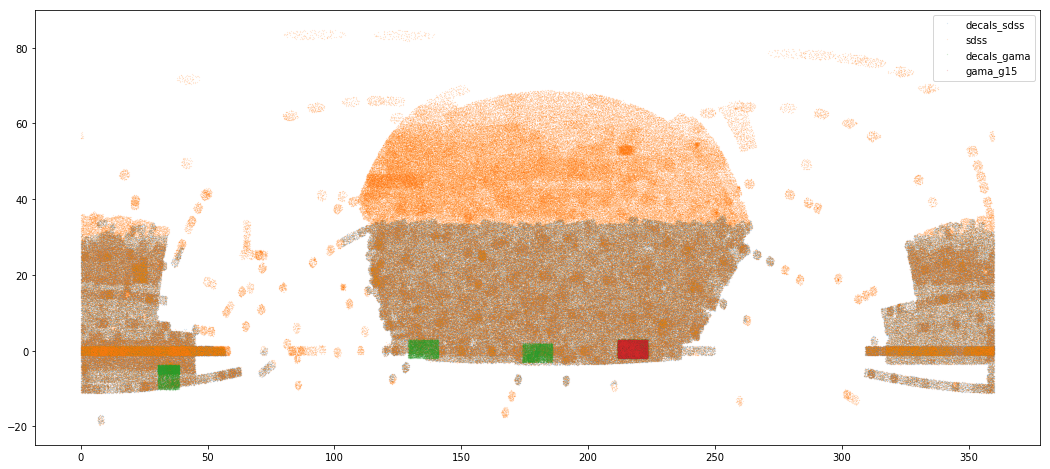

In [222]:
plt.figure(figsize=(18, 8))
plt.plot(decals_sdss['RA'][::10], decals_sdss['DEC'][::10], '.', markersize=0.4, alpha=0.3, label = 'decals_sdss')
plt.plot(sdss_short['PLUG_RA'][::10], sdss_short['PLUG_DEC'][::10], '.', markersize=0.4, alpha=0.3, label = 'sdss')
plt.plot(decals_gama['RA'][::10], decals_gama['DEC'][::10], '.', markersize=0.4, alpha=0.4, label = 'decals_gama')
plt.plot(gama_g15['RA'][::10], gama_g15['DEC'][::10], '.', markersize=0.4, alpha=0.4, label = 'gama_g15')
#plt.axis([0, 360, -23, 35])
plt.legend()
plt.show()